In [5]:
import os

import pyspark
from pyspark.sql.types import IntegerType, FloatType
import pyspark.sql.functions as sf

sparkql = pyspark.sql.SparkSession.builder.master('local').getOrCreate()

data_dir = './data'
coffee_data = 'coffee.csv'

#Added schema to make sure all the columns are floats except for the 'Date' and 'Currency' columns
schema = 'Date date, Open float, High float, Low float, Close float, Volume float, Currency string'

#read csv into spark dataframe
df = sparkql.read.csv(os.path.join(data_dir, coffee_data), header=True, schema=schema)

print(df.columns)

df.printSchema()
df.show(3)

['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Currency']
root
 |-- Date: date (nullable = true)
 |-- Open: float (nullable = true)
 |-- High: float (nullable = true)
 |-- Low: float (nullable = true)
 |-- Close: float (nullable = true)
 |-- Volume: float (nullable = true)
 |-- Currency: string (nullable = true)

+----------+------+-----+------+------+------+--------+
|      Date|  Open| High|   Low| Close|Volume|Currency|
+----------+------+-----+------+------+------+--------+
|2000-01-03|122.25|124.0| 116.1| 116.5|6640.0|     USD|
|2000-01-04|116.25|120.5|115.75|116.25|5492.0|     USD|
|2000-01-05| 115.0|121.0| 115.0| 118.6|6165.0|     USD|
+----------+------+-----+------+------+------+--------+
only showing top 3 rows



In [20]:
# Columns from Aggregate Functions section

# Add a column to the DataFrame where the values are the difference between 'Open' and 'Close'
df = df.withColumn('diff_open_close', sf.round(sf.col('Open') - sf.col('Close'), 2))

#Add a column to the DataFrame where the values are the difference between 'High' and 'Low'.
df = df.withColumn('diff_high_low', sf.round(sf.col('High') - sf.col('Low'),2))

#Add a column to the DataFrame where the values are 'True' if the volume for that day was 100 or above, and otherwise 'False'.
df = df.withColumn('vol_greater_100', sf.col('Volume') > 100)

#Add a column that contains the absolute values of the numbers in diff_open_close
df = df.withColumn('abs_val_open_close', sf.round(sf.abs(sf.col('diff_open_close')),2))

#Add a column with the average of opening, high, low, and closing cost times the volume
df = df.withColumn('net_sales', sf.round(((sf.col('Open') + sf.col('Close') + sf.col('High') + sf.col('Low'))/4) * sf.col('Volume'), 2))

df.show(10)

+----------+------+------+------+------+-------+--------+---------------+-------------+---------------+------------------+----------+
|      Date|  Open|  High|   Low| Close| Volume|Currency|diff_open_close|diff_high_low|vol_greater_100|abs_val_open_close| net_sales|
+----------+------+------+------+------+-------+--------+---------------+-------------+---------------+------------------+----------+
|2000-01-03|122.25| 124.0| 116.1| 116.5| 6640.0|     USD|           5.75|          7.9|           true|              5.75| 794891.01|
|2000-01-04|116.25| 120.5|115.75|116.25| 5492.0|     USD|            0.0|         4.75|           true|               0.0| 643593.75|
|2000-01-05| 115.0| 121.0| 115.0| 118.6| 6165.0|     USD|           -3.6|          6.0|           true|               3.6| 723771.01|
|2000-01-06| 119.0| 121.4| 116.5|116.85| 5094.0|     USD|           2.15|          4.9|           true|              2.15| 603320.63|
|2000-01-07|117.25|117.75| 113.8|114.15| 6855.0|     USD|     

In [44]:
# Stats section

# average of the values in the column that has the absolute values of the difference between 'Open' and 'Close'
df.agg(sf.round(sf.avg(sf.col('abs_val_open_close')),2)).show()

# count of values where the 'Volume' was less than 100
df.agg(sf.round(sf.avg(sf.col('abs_val_open_close')),2)).show()

vol_less_hund_count = df.select('Volume').where(df.Volume < 100).count()
print(vol_less_hund_count)

# average 'Open' value
df.agg(sf.round(sf.avg(sf.col('Open')),2)).show()

# highest 'High' value
df.agg(sf.max(sf.col('High'))).show()

+---------------------------------+
|round(avg(abs_val_open_close), 2)|
+---------------------------------+
|                             1.76|
+---------------------------------+

1638
+-------------------+
|round(avg(Open), 2)|
+-------------------+
|             126.05|
+-------------------+

+---------+
|max(High)|
+---------+
|   306.25|
+---------+



In [47]:
#Write File section

#Save df that includes the four added columns to parquet file
df.write.parquet(os.path.join(data_dir,'output.parquet'))

#code if prefer to export to CSV: df.write.csv(os.path.join(data_dir,'output.csv'),header=True)

<AxesSubplot:>

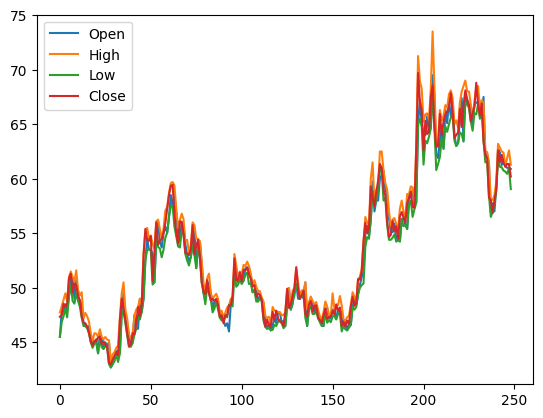

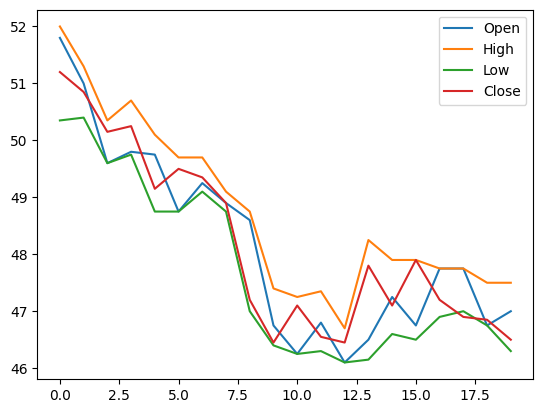

In [56]:
#Bonus 1

#Line graph for open, high, low, close for each available day of 2002
pdf = df.filter((sf.year("Date") == 2002)).select('Open', 'High', 'Low', 'Close').toPandas()

pdf.plot.line()

#Line graph for open, high, low, close for each available day of June 2002
pdf_june = df.filter((sf.year("Date") == 2002) & (sf.month("Date")==6)).select('Open', 'High', 'Low', 'Close').toPandas()

pdf_june.plot.line()